# (ZIP Code 1) A Small Digit Recognition Problem
Reproducing Yan LeCun http://yann.lecun.com/exdb/publis/pdf/lecun-89.pdf

The database is composed of 480 examples of numerals represented as 16 pixel by 16 pixel binary images. 12 example of each of the 10 digits were hand-drawn by a single person on a 16 by 13 bitmap using a mouse. Each image was then used to generate 4 examples by putting the original image in 4 consecutive horizontal positions on a 16 by 16 bitmap. The training set was then formed by choosing 32 examples of each class at random amoung the complete set of 480 images. The remaining 16 examples of each class were used as the test set. Thus the training set contained 320 images, and the test set contained 160 images.

NOTE. Here we reproduce the architecture of the LeCun neural networks. The loss function and training approach are slightly different.

## Load and Prepare Data
The images originally used by LeCun are not available now, so I've drawn them myself. It is stored in a bmp file.

In [1]:
import numpy as np
from PIL import Image
from matplotlib import transforms, pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

In [2]:
# load monochrome bmp file and convert it to int numpy array
img = np.array(Image.open('../data/numerals.bmp')).astype(int)

In [3]:
# construct 480 16x16 examples with only one channel (usually 3 for RGB)
X = np.zeros(shape=(480, 16, 16, 1))
y = np.zeros(shape=(480, 1))
example_idx = 0
for i in range(10):
    for j in range(12):
        # crop 16x13 patch from the data image
        # one pixel is between numerals, so multipy on 17 and 14
        si, fi = i*17, i*17+16
        sj, fj = j*14, j*14+13
        patch = 1-img[si:fi, sj:fj]
        # shift patch to get 4 examples from one
        for k in range(4):
            X[example_idx, 0:16, k:k+13, 0] = patch
            y[example_idx, 0] = i
            example_idx += 1

In [4]:
# perform a stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=320, random_state=10, stratify=y)
# convert classes to one-hot vectors
ohe = OneHotEncoder(categories='auto').fit(y)
Y_train = ohe.transform(y_train).toarray()
Y_test = ohe.transform(y_test).toarray()

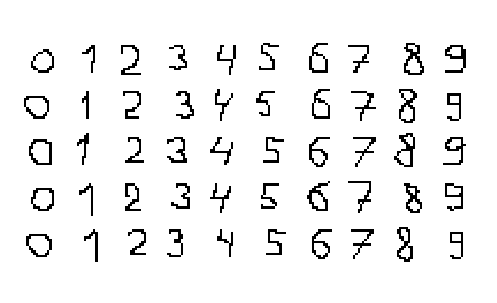

In [5]:
# show some training examples
w = 20  # pixels for one digit
result = np.zeros(shape=(4+w*5, 4+w*10))
for d in range(10):
    d_idx = np.squeeze(np.argwhere(y_train == d))[:, 0]
    d_idx = np.random.choice(d_idx, 5, replace=False)
    for i, idx in enumerate(d_idx):
        result[i*w+4:i*w+20, d*w+4:d*w+20] = -X_train[idx].reshape((16, 16))
fig, ax = plt.subplots(figsize=(5.5, 3.3), dpi=110)
ax.imshow(result, cmap="gray")
ax.set_aspect('equal', 'datalim')
ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

## Training

In [6]:
from sklearn.metrics import accuracy_score
import os
# don't use GPU
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow as tf

In [7]:
# all nets will use the same loss function and the optimization step
def build_optimizer_step(learning_rate, y_true, y_hat):
    # PAGE 406. The networks all have sigmoidal output units, and
    #           were all fit with the sum-of-squares error function.
    # squared_error = (y_true - y_hat)**2
    # loss = tf.reduce_mean(tf.reduce_sum(squared_error, reduction_indices=1))

    # NOTE. We'll use multinominal cross-entropy loss function
    cross_entropy = y_true*tf.log(y_hat)
    loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices=1))
    opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return opt

In [8]:
# this training procedure will be used for all nets
def train(session, x_tensor, y_tensor, y_hat_tensor, lr, n_epochs):
    accuracy_test = []
    optimizer_step = build_optimizer_step(lr, y_tensor, y_hat_tensor)
    session.run(tf.global_variables_initializer())
    for e in range(n_epochs):
        for b in range(X_train.shape[0]):
            # give images to the optimizer one by one
            fd_train = {x_tensor: X_train[b:b+1], y_tensor: Y_train[b:b+1]}
            session.run(optimizer_step, fd_train)
        # calculate test accuracy after each epoch
        fd_test = {x_tensor: X_test}
        y_test_hat = np.argmax(session.run(y_hat_tensor, fd_test), axis=1)
        accuracy_test.append(accuracy_score(y_test, y_test_hat))
    return accuracy_test

In [9]:
# start tensorflow session
session = tf.Session()

# define placeholders for features and targets
x = tf.placeholder(tf.float32, shape=[None, 16, 16, 1])
y = tf.placeholder(tf.float32, shape=[None, 10])

## Net-1
No hidden layer, equivalent to multinomial logistic regression.

In [10]:
# use xavier initializer for weights' starting values
initializer = tf.contrib.layers.xavier_initializer(seed=1)

# parameters
A = tf.Variable(initializer([256, 10]))
a0 = tf.Variable(initializer([1, 10]))
# number of trainable parameters calculation
parms = [A, a0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# neural network computation graph
x_flatten = tf.reshape(x, [-1, 256])
y_hat = tf.nn.softmax(a0 + x_flatten@A)

# train
net1_size = session.run(size)
net1_accuracy = train(session, x, y, y_hat, 7e-3, 30)

## Net-2
One hidden layer, 12 hidden units fully connected.

In [11]:
# use xavier initializer for weights' starting values
initializer = tf.contrib.layers.xavier_initializer(seed=1)

# parameters
n_hidden = 12
A = tf.Variable(initializer([256, n_hidden]))
a0 = tf.Variable(initializer([1, n_hidden]))
B = tf.Variable(initializer([n_hidden, 10]))
b0 = tf.Variable(initializer([10]))
# number of trainable parameters calculation
parms = [A, a0, B, b0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# neural network computation graph
x_flatten = tf.reshape(x, [-1, 256])
Z = tf.nn.tanh(a0 + x_flatten@A)
y_hat = tf.nn.softmax(b0 + Z@B)

# train
net2_size = session.run(size)
net2_accuracy = train(session, x, y, y_hat, 7e-3, 30)

## Net-3
Two hidden layers locally connected.

In [12]:
# use xavier initializer for weights' starting values
initializer = tf.contrib.layers.xavier_initializer(seed=1)

# parameters
A = tf.Variable(initializer([1, 8, 8, 9]))
a0 = tf.Variable(initializer([1, 8, 8]))
B = tf.Variable(initializer([1, 4, 4, 25]))
b0 = tf.Variable(initializer([1, 4, 4]))
C = tf.Variable(initializer([16, 10]))
c0 = tf.Variable(initializer([10]))
# number of trainable parameters calculation
parms = [A, a0, B, b0, C, c0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# neural network computation graph
patches1 = tf.extract_image_patches(
    images=x,
    ksizes=[1, 3, 3, 1],
    strides=[1, 2, 2, 1],
    rates=[1, 1, 1, 1],
    padding='SAME'
)
Z1 = tf.expand_dims(tf.nn.tanh(tf.reduce_sum(patches1 * A, axis=3)+a0), -1)

patches2 = tf.extract_image_patches(
    images=Z1,
    ksizes=[1, 5, 5, 1],
    strides=[1, 1, 1, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)
Z2 = tf.reshape(
    tf.nn.tanh(tf.reduce_sum(patches2 * B, axis=3)+b0),
    [-1, 16])
y_hat = tf.nn.softmax(c0 + Z2@C)

# train
net3_size = session.run(size)
net3_accuracy = train(session, x, y, y_hat, 7e-3, 30)

## Net-4
Two hidden layers, locally connected with weight sharing.

In [13]:
# use xavier initializer for weights' starting values
initializer = tf.contrib.layers.xavier_initializer(seed=1)

# parameters
A = tf.Variable(initializer([3, 3, 1, 2]))
a0 = tf.Variable(initializer([1, 8, 8, 2]))
B = tf.Variable(initializer([1, 4, 4, 50]))
b0 = tf.Variable(initializer([1, 4, 4]))
C = tf.Variable(initializer([16, 10]))
c0 = tf.Variable(initializer([10]))
# number of trainable parameters calculation
parms = [A, a0, B, b0, C, c0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# neural network computation graph
Z1 = tf.nn.tanh(
    tf.nn.conv2d(
        input=x,
        filter=A,
        strides=[1, 2, 2, 1],
        padding='SAME'
    ) + a0)

patches = tf.extract_image_patches(
    images=Z1,
    ksizes=[1, 5, 5, 1],
    strides=[1, 1, 1, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)
Z2 = tf.reshape(tf.nn.tanh(tf.reduce_sum(patches*B, axis=3)+b0), [-1, 16])
y_hat = tf.nn.softmax(c0 + Z2@C)

# train
net4_size = session.run(size)
net4_accuracy = train(session, x, y, y_hat, 7e-3, 30)

## Net-5
Two hidden layers, locally connected, two levels of weight sharing.

In [14]:
# use xavier initializer for weights' starting values
initializer = tf.contrib.layers.xavier_initializer(seed=20)

# parameters
A = tf.Variable(initializer([3, 3, 1, 2]))
a0 = tf.Variable(initializer([1, 8, 8, 2]))
B = tf.Variable(initializer([5, 5, 2, 4]))
b0 = tf.Variable(initializer([1, 4, 4, 4]))
C = tf.Variable(initializer([64, 10]))
c0 = tf.Variable(initializer([10]))
# number of trainable parameters calculation
parms = [A, a0, B, b0, C, c0]
size = tf.reduce_sum([tf.size(p) for p in parms])

# neural network computation graph
Z1 = tf.nn.tanh(
    tf.nn.conv2d(
        input=x,
        filter=A,
        strides=[1, 2, 2, 1],
        padding='SAME'
    ) + a0)

Z2 = tf.reshape(
    tf.nn.tanh(
        tf.nn.conv2d(
            input=Z1,
            filter=B,
            strides=[1, 1, 1, 1],
            padding='VALID') + b0),
    [-1, 64])
y_hat = tf.nn.softmax(c0 + Z2@C)

# train
net5_size = session.run(size)
net5_accuracy = train(session, x, y, y_hat, 7e-3, 30)

In [15]:
# PAGE 407. TABLE 11.1. Test set performance of five different neural networks
#           on a handwritten digit classification example (Le Cun, 1989).
architectures = [
    'Net-1: Single layer network',
    'Net-2: Two layer network',
    'Net-3: Locally connected',
    'Net-4: Constrained network 1',
    'Net-5: Constrained network 2']
sizes = [net1_size, net2_size, net3_size, net4_size, net5_size]
test_scores = [net1_accuracy, net2_accuracy, net3_accuracy,
               net4_accuracy, net5_accuracy]
best_scores = [max(score) for score in test_scores]

print('         Network Architecture   Weights   % Correct')
print('---------------------------------------------------')
for n, s, b in zip(architectures, sizes, best_scores):
    print(f'{n:<28} {s:>10} {100*b:>10.1f}%')

         Network Architecture   Weights   % Correct
---------------------------------------------------
Net-1: Single layer network        2570       91.9%
Net-2: Two layer network           3214       94.4%
Net-3: Locally connected           1226       94.4%
Net-4: Constrained network 1       1132       96.9%
Net-5: Constrained network 2       1060       98.8%


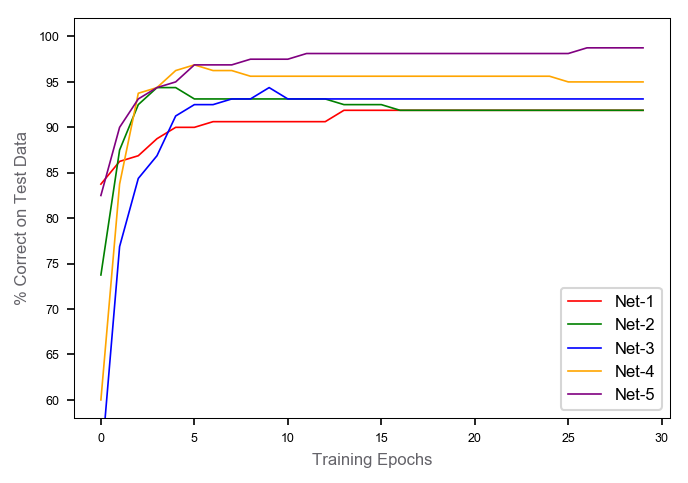

In [16]:
# PAGE 406. FIGURE 11.11. Test performance curves, as a function of the number
#           of training epochs, for the five networks of Table 11.1 applied to
#           the ZIP code data. (Le Cun, 1989)
fig, ax = plt.subplots(figsize=(5.13, 3.53), dpi=150)
x_vals = range(30)
lines = zip(
    test_scores, ['red', 'green', 'blue', 'orange', 'purple'], architectures)
for scores, color, arc in lines:
    ax.plot(x_vals, [100*s for s in scores], linewidth=0.8, color=color,
            label=arc[:5])
ax.set_xlabel('Training Epochs', color=GRAY4, fontsize=8)
ax.set_ylabel('% Correct on Test Data', color=GRAY4, fontsize=8)
ax.set_ylim(58, 102)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)
_ = ax.legend(loc='lower right', prop={'size': 8})

# (ZIP Code 2)
Normalized handwritten digits, automatically scanned from envelopes by the U.S. Postal Service. The original scanned digits are binary and of different sizes and orientations; the images here have been deslanted and size normalized, resulting in 16 x 16 grayscale images (Le Cun et al., 1990).

The data is in a numpy compressed file, and each row consists of the digit id (0-9) followed by the 256 grayscale values. The last column contains is_test flag 0 for train and 1 for test observations.

There are 7291 training observations and 2007 test observations.

The test set is notoriously "difficult", and a 2.5% error rate is excellent. These data were kindly made available by the neural network group at AT&T research labs (thanks to Yann Le Cunn).

http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf

http://yann.lecun.com/exdb/publis/pdf/lecun-99.pdf

In [1]:
from scipy.special import logsumexp
import cvxpy as cp
import pandas as pd
from matplotlib import transforms, pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

## Load and Prepare Data

In [2]:
# PAGE 404. Figure 11.9 shows some examples of normalized handwritten digits,
#           automatically scanned from envelopes by the U.S. Postal Service.
#           The original scanned digits are binary and of different sizes and
#           orientations; the images shown here have been deslanted and size
#           normalized, resulting in 16× 16 grayscale images (Le Cun et al.,
#           1990). These 256 pixel values are used as inputs to the neural
#           network classifier.

# load numpy array from the compressed file
arr = np.load('../data/zip.npy.npz')['arr_0']
# do train-test split by the last column
train, test = arr[arr[:, -1] == 0], arr[arr[:, -1] == 1]
X_train, X_test = train[:, 1:-1], test[:, 1:-1]
y_train, y_test = train[:, 0].astype(int), test[:, 0].astype(int)

# do one hot labels encoding
ohe = OneHotEncoder(categories='auto')
Y_train_one_hot = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
Y_test_one_hot = ohe.fit_transform(y_test.reshape(-1, 1)).toarray()

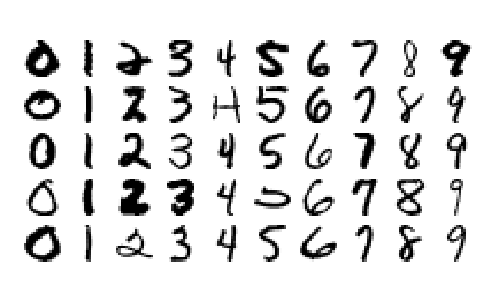

In [3]:
# PAGE 404. FIGURE 11.9. Examples of training cases from ZIP code data. Each
#           image is a 16 × 16 8-bit grayscale representation of a handwritten
#           digit.
w = 20  # pixels for one digit
result = np.ones(shape=(4+w*5, 4+w*10))
for d in range(10):
    d_idx = np.squeeze(np.argwhere(y_train == d))
    d_idx = np.random.choice(d_idx, 5, replace=False)
    for i, idx in enumerate(d_idx):
        result[i*w+4:i*w+20, d*w+4:d*w+20] = -X_train[idx].reshape((16, 16))
fig, ax = plt.subplots(figsize=(5.5, 3.3), dpi=110)
ax.imshow(result, cmap="gray")
ax.set_aspect('equal', 'datalim')
ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

## Principal Components

In [4]:
from sklearn.decomposition import PCA

In [5]:
# PAGE 536. Principal components are a useful tool for dimension reduction and
#           compression. We illustrate this feature on the handwritten digits
#           data described in Chapter 1. Figure 14.22 shows a sample of 130
#           handwritten 3’s, each a digitized 16 × 16 grayscale image, from a
#           total of 658 such 3’s. We see considerable variation in writing
#           styles, character thickness and orientation. We consider these
#           images as points xi in IR256, and compute their principal
#           components via the SVD (14.54).
idx_3 = np.where(y_train == 3)[0]
X_train_3 = X_train[idx_3]

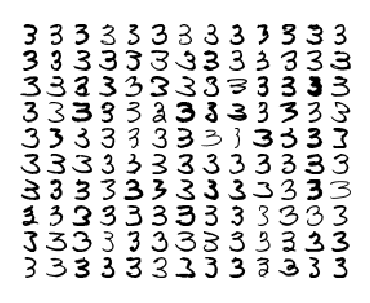

In [6]:
# PAGE 537. FIGURE 14.22. A sample of 130 handwritten 3’s shows a variety of
#           writing styles.
result = np.ones(shape=(4+w*10, 4+w*13))
rnd = np.random.choice(idx_3, 130, replace=False)
for n in range(130):
    i, j = n // 13, n % 13
    result[i*w+4:i*w+20, j*w+4:j*w+20] = -X_train[rnd[n]].reshape((16, 16))
fig, ax = plt.subplots(figsize=(4, 3.3), dpi=110)
ax.imshow(result, cmap="gray")
ax.set_aspect('equal', 'datalim')
ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)

In [7]:
# PAGE 536. Figure 14.23 shows the first two principal components of
#           these data. For each of these first two principal components ui1
#           and ui2, we computed the 5%, 25%, 50%, 75% and 95% quantile points,
#           and used them to define the rectangular grid superimposed on the
#           plot. The circled points indicate those images close to the
#           vertices of the grid, where the distance measure focuses mainly on
#           these projected coordinates, but gives some weight to the
#           components in the orthogonal subspace.
X_train_3_pca = PCA(n_components=2).fit_transform(X_train_3)
x_grid = np.percentile(X_train_3_pca[:, 0], [5, 25, 50, 75, 95])
y_grid = np.percentile(X_train_3_pca[:, 1], [5, 25, 50, 75, 95])
x_grid[2], y_grid[2] = 0, 0

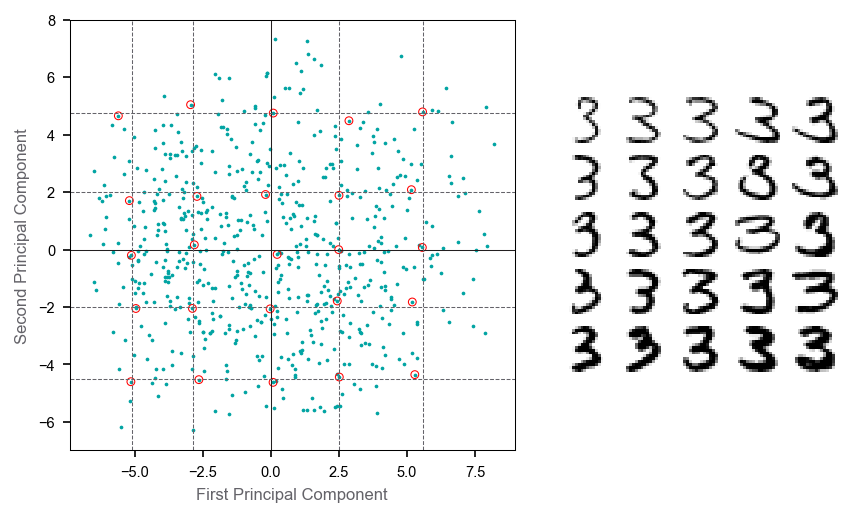

In [8]:
# PAGE 538. FIGURE 14.23. (Left panel:) the first two principal components of
#           the handwritten threes. The circled points are the closest
#           projected images to the vertices of a grid, defined by the marginal
#           quantiles of the principal components. (Right panel:) The images
#           corresponding to the circled points. These show the nature of the
#           first two principal components.
fig, axarr = plt.subplots(1, 2, figsize=(6.7, 3.8), dpi=150,
                          gridspec_kw=dict(width_ratios=[3, 2]))
plt.subplots_adjust(wspace=0.1)
for s in axarr[1].spines.values():
    s.set_visible(False)
axarr[1].tick_params(
    bottom=False, labelbottom=False, left=False, labelleft=False)
ax = axarr[0]
ax.scatter(X_train_3_pca[:, 0], X_train_3_pca[:, 1], s=0.6, color='#02A4A3')
ax.set_xlabel('First Principal Component', color=GRAY4, fontsize=8)
ax.set_ylabel('Second Principal Component', color=GRAY4, fontsize=8)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)
ax.axhline(0, linewidth=0.5, color=GRAY1)
ax.axvline(0, linewidth=0.5, color=GRAY1)
for i in range(5):
    if i != 2:
        ax.axhline(y_grid[i], linewidth=0.5, color=GRAY4, linestyle='--')
        ax.axvline(x_grid[i], linewidth=0.5, color=GRAY4, linestyle='--')

img = np.ones(shape=(4+w*5, 4+w*5))
for i in range(5):
    for j in range(5):
        v = X_train_3_pca - np.array([x_grid[i], y_grid[j]])
        v = np.sqrt(np.sum(v**2, axis=-1))
        idx = np.argmin(v)
        ax.scatter(
            X_train_3_pca[idx:idx+1, 0], X_train_3_pca[idx:idx+1, 1], s=14,
            facecolors='none', edgecolors='r', linewidth=0.5)
        img[j*w+4:j*w+20, i*w+4:i*w+20] = -X_train_3[idx].reshape((16, 16))

ax = axarr[1]
ax.imshow(img, cmap="gray")
ax.set_aspect('equal', 'datalim')

## Archetypal Analysis
https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Chen_Fast_and_Robust_2014_CVPR_paper.pdf

In [9]:
# PAGE 554. This method, due to Cutler and Breiman (1994), approximate data
#           points by prototypes that are themselves linear combinations of
#           data points. In this sense it has a similar flavor to K-means
#           clustering. However, rather than approximating each data point by a
#           single nearby prototype, archetypal analysis approximates each data
#           point by a convex combination of a collection of prototypes.
X = X_train_3.T
m, n = X.shape

In [10]:
# PAGE 554. This function is minimized in an alternating fashion, with each
#           separate minimization involving a convex optimization. The overall
#           problem is not convex however, and so the algorithm converges to a
#           local minimum of the criterion.
archetypes = []
for p in range(2, 5):
    idxs = np.random.choice(m, p, replace=False)
    Z = X[:, idxs]
    B = np.zeros(shape=(n, p))
    for i, idx in enumerate(idxs):
        B[idx, i] = 1

    for i in range(30):
        A = cp.Variable((p, n))
        objective = cp.Minimize(cp.norm(X - Z@A, 'fro'))
        constraint = [0 <= A, A <= 1, cp.sum(A, axis=0) == 1]
        prob = cp.Problem(objective, constraint)
        result = prob.solve()
        A_ = A.value

        R = X - Z@A_
        for j in range(p):
            aj = A_[j].reshape((1, n))
            aj_norm = aj@aj.T
            zj = Z[:, j].reshape((m, 1))

            b = cp.Variable((n, 1))

            objective = cp.Minimize(cp.norm(R@aj.T/aj_norm + zj - X@b))
            constraint = [0 <= b, b <= 1, cp.sum(b) == 1]

            prob = cp.Problem(objective, constraint)
            result = prob.solve()

            R = R + (zj - X@b.value)@aj
            Z[:, j] = (X@b.value)[:, 0]
    archetypes.append(Z)

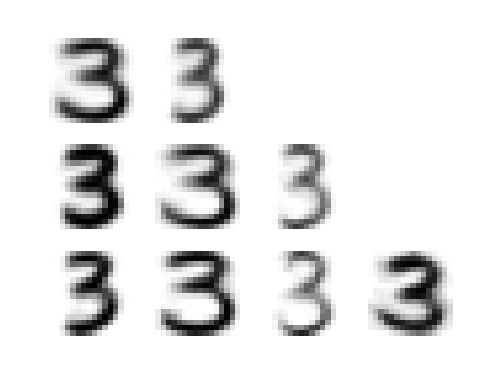

In [11]:
# PAGE 558. FIGURE 14.36. Archetypal analysis applied to the database of
#           digitized 3's. The rows in the figure show the resulting achetypes
#           from three runs, specifying two, three and four archetypes,
#           respectively.
img = np.ones(shape=(4+w*3, 4+w*4))
for j in range(3):
    for i in range(archetypes[j].shape[1]):
        img[j*w+4:j*w+20, i*w+4:i*w+20] = -archetypes[j][:, i].reshape(
            (16, 16))

fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
ax.imshow(img, cmap="gray")
ax.set_aspect('equal', 'datalim')
ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
for spine in ax.spines.values():
    spine.set_visible(False)